In [38]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
charging_per_day = pd.read_csv("charging_per_day.csv")
processed_df = charging_per_day.drop(columns=['Timestamp', 'Hour_0'])

In [40]:
features_to_scale = ['Charging_per_day', 'MAX. TEMP(F)', 'MIN. TEMP(F)', 'Precipitation (Inches)', 'Snowfall (Inches)', 'Snow Cover (Inches)']
features = processed_df[features_to_scale]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# For boolean or one-hot features, ensure they are converted to integers
boolean_and_onehot_features = processed_df.drop(columns=features_to_scale).astype(int).values

# Concatenate scaled continuous features and boolean/one-hot features
data_normalized = np.concatenate((scaled_features, boolean_and_onehot_features), axis=1)

# Ensure the concatenated array is of a uniform numerical type that PyTorch can handle
data_normalized = np.array(data_normalized, dtype=np.float32)

# Convert to PyTorch tensor
data_normalized_tensor = torch.FloatTensor(data_normalized)

In [41]:
# Creating sequences to train on

# For the 7-day ahead task
def create_inout_sequences_multivariate(input_data, tw, prediction_gap=7):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw - prediction_gap + 1):
        seq = input_data[i:i+tw]
        label = input_data[i+tw+prediction_gap-1, 0]  # Adjusting for 7-day ahead forecasting
        inout_seq.append((seq, label))
    return inout_seq

# Splitting the dataset into train and test datasets
split_size = int(len(data_normalized_tensor) * 0.8)  # 80% of the data for training

# Split the normalized data into training and test sets
train_data = data_normalized_tensor[:split_size]
test_data = data_normalized_tensor[split_size:]

# Window size and batch size
window_size = 20
batch_size = 32

# Create sequences for training and test data with a 7-day ahead prediction
train_seqs = create_inout_sequences_multivariate(train_data, window_size, 7)
test_seqs = create_inout_sequences_multivariate(test_data, window_size, 7)


# DataLoader
class MultivariateTimeSeriesDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence, label = self.sequences[index]
        return sequence, label

# Training DataLoader
train_dataset = MultivariateTimeSeriesDataset(train_seqs)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test DataLoader (This will not be shuffled to make it a more realistic scenario)
test_dataset = MultivariateTimeSeriesDataset(test_seqs)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [42]:
# Using LSTM as a baseline model and we will build on transformer models post that


class EVChargingLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size=100, output_size=1):
        super(EVChargingLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # Specifying batch_first=True for easier compatibility with input shapes
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Automatically determining batch size from input
        batch_size = input_seq.size(0)

        # Initializing hidden state for each batch
        hidden_cell = (torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device),
                       torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device))

        # Forward pass through LSTM layer
        lstm_out, _ = self.lstm(input_seq, hidden_cell)

        # Only taking the output from the final timestep
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

Epoch 1 Loss: 0.04193518566036666
Epoch 2 Loss: 0.03614387819888415
Epoch 3 Loss: 0.030861222875063068
Epoch 4 Loss: 0.026689326735558332
Epoch 5 Loss: 0.023416938863832643
Epoch 6 Loss: 0.020777596247003035
Epoch 7 Loss: 0.01834025168446479
Epoch 8 Loss: 0.016546106880047807
Epoch 9 Loss: 0.015249151857224879
Epoch 10 Loss: 0.014433209215187363
Epoch 11 Loss: 0.013815179544811448
Epoch 12 Loss: 0.013501774364461502
Epoch 13 Loss: 0.013201302184757811
Epoch 14 Loss: 0.012948984875240259
Epoch 15 Loss: 0.012878356380733076
Epoch 16 Loss: 0.012876415702824792
Epoch 17 Loss: 0.012598162128900489
Epoch 18 Loss: 0.012461387466087385
Epoch 19 Loss: 0.012375320816688516
Epoch 20 Loss: 0.012277780859558671
Epoch 21 Loss: 0.012283043866908108
Epoch 22 Loss: 0.012050987497248032
Epoch 23 Loss: 0.011919803951901418
Epoch 24 Loss: 0.011772311732379926
Epoch 25 Loss: 0.011746363386649776
Epoch 26 Loss: 0.01172851660737285
Epoch 27 Loss: 0.011531371795744807
Epoch 28 Loss: 0.011425910595183572
Epoch

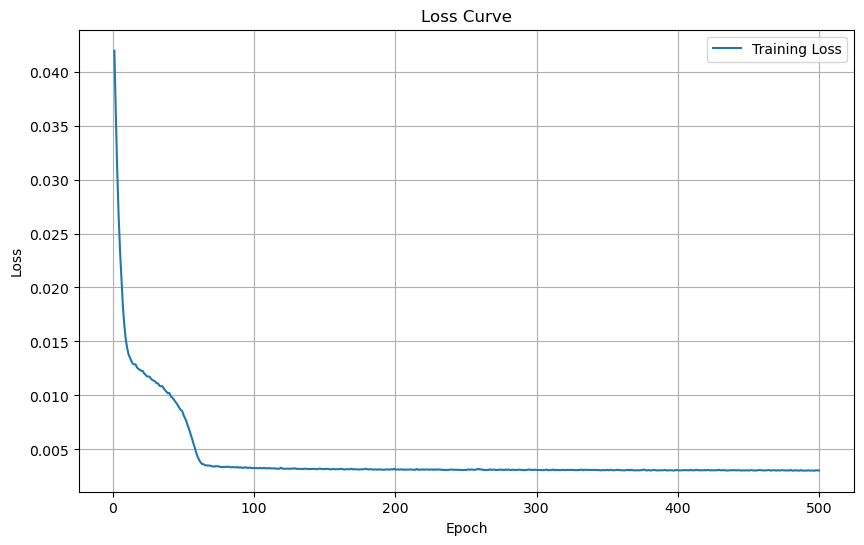

In [43]:
# Model hyperparameters
input_size = 18  
hidden_layer_size = 100
output_size = 1

# Initialize the model
model = EVChargingLSTM(input_size, hidden_layer_size, output_size)

# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
epochs = 500
model.train()

train_loss = []

for i in range(epochs):
    epoch_loss = 0  # Initialize loss for the epoch
    n_batches = 0
    for sequences, labels in train_dataloader:
        optimizer.zero_grad()
        y_pred = model(sequences)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1

    average_epoch_loss = epoch_loss / n_batches
    train_loss.append(average_epoch_loss)  # Append the average loss for the epoch
    print(f'Epoch {i+1} Loss: {average_epoch_loss}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')  # Dynamic range based on epochs
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# Evaluation
model.eval()
test_losses = []

with torch.no_grad():
    for sequences, labels in test_dataloader:
        y_test_pred = model(sequences)
        test_loss = loss_function(y_test_pred, labels.unsqueeze(1))  # Ensure label dimensions match
        test_losses.append(test_loss.item())

average_test_loss = sum(test_losses) / len(test_losses)
print(f'Test Loss: {average_test_loss}')

Test Loss: 0.024533372838050127
